## Kernel Methods Project
Team name: A_O

In [1]:
import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_auc_score

### Load the dastasets

In [2]:
Xtr = pd.read_csv('/content/Xtr.csv')
Xtr_vec = pd.read_csv('/content/Xtr_vectors.csv')
Xte = pd.read_csv('/content/Xte.csv')
Xte_vec = pd.read_csv('/content/Xte_vectors.csv')
Ytr= pd.read_csv('/content/Ytr.csv')

In [3]:
Xtr.head()

,Id,Sequence
0,1,TCTTCCATCGTTGATAGTGTTACATTGAAGAATGCGACGATCCATC...
1,2,CTTCTTCAGTAATTACCTCAAGAGACGTTTAGTCTCTAATGGTGTT...
2,3,GTCTATGGTGCTGCTGTTGTTTACCGGGGTACAACAACTTACAAAT...
3,4,ATTCGCCATGAGTAAATTTCCCCTTAAATTAGGGGGTTCAGCTGTT...
4,5,CAGACAAAACATTTGTGTCTGGTAACTGTGATGTTGTAATAGGAAT...


In [4]:
Xtr_vec.head()

,Id,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,1,0.1406,0.0625,0.0781,0.1094,0.0625,0.0312,0.0312,0.1406,0.0781,...,0.0625,0.1719,0.0781,0.0312,0.0625,0.1719,0.0781,0.1094,0.1406,0.1250
1,2,0.1250,0.1250,0.0781,0.0938,0.0625,0.0469,0.0625,0.1094,0.1406,...,0.0781,0.1406,0.1094,0.0625,0.0312,0.1406,0.0625,0.1406,0.1250,0.1406
2,3,0.1406,0.1719,0.0156,0.0781,0.1406,0.1094,0.0938,0.0469,0.0312,...,0.1406,0.0938,0.0938,0.0156,0.0625,0.0781,0.1562,0.0469,0.0781,0.1094
3,4,0.1406,0.0938,0.0781,0.1250,0.1250,0.0469,0.0312,0.0781,0.0938,...,0.0312,0.2031,0.1094,0.0469,0.0469,0.1875,0.1094,0.1562,0.1406,0.1875
4,5,0.2188,0.1094,0.1094,0.2031,0.1250,0.0625,0.0156,0.1094,0.1406,...,0.0312,0.0938,0.0781,0.0156,0.0312,0.1250,0.1719,0.0781,0.0625,0.1719


In [5]:
Xtr_vec.shape

(2000, 65)

In [6]:
Ytr.head()

,Id,Covid
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


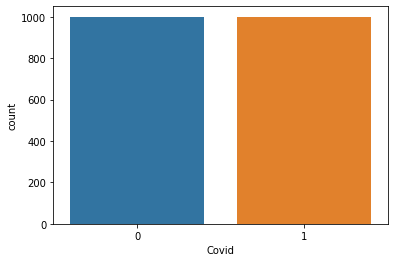

In [7]:
# Visualize training target 
sns.countplot(x="Covid", data=Ytr)

Change the target from {0,1} to {-1,1} because the algorithms were writting for case where y={-1,1}

In [8]:
Ytr['Covid'] = 2*Ytr['Covid']-1

## Build  model

In [9]:
# First drop the "Id" column
Xtr_vec=Xtr_vec.drop(['Id'],axis=1)
# Split the dataset into training set and validation set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    Xtr_vec, Ytr['Covid'], test_size=0.33, random_state=42)
X_train.shape, y_train.shape

((1340, 64), (1340,))

### 1.Logistic Ridge Regression with gradient descent (GD)

In [10]:
# Logistic Ridge Regression (LRR) with gradient descent (GD)
def solveLRR_gradient(y, X, lam, h=0.01, max_iter=500, eps=1e-3):
    '''
    lam: Regularization parameter
    max_iter: Max number of iterations of gradient descent
    eps: Tolerance for stopping criteria 
    '''
    n, p = X.shape
    assert (len(y) == n)
    
    beta_old = np.zeros(p)
    
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
            
    for i in range(max_iter):
        # yi beta^T xi
        f = (X * y[:, None]).dot(beta_old)
        gradient = - 1 / n * (y * sigmoid(-f)).dot(X)
        gradient += 2 * lam * beta_old
        
        # Step
        beta_new = beta_old - h * gradient
        
        if np.sum((beta_new-beta_old)**2) < eps:
            break
        beta_old = beta_new
           
    return (beta_new)

In [11]:
# Fit LRR and compute its parameters
lam = 0.0001
beta = solveLRR_gradient(y_train, X_train, lam)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


In [12]:
# Compute predicted probabilities and classes
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

probas_pred_train = sigmoid(X_train.dot(beta))
probas_pred = sigmoid(X_test.dot(beta))

y_pred_train=np.where(probas_pred_train<0.5,-1,1)
y_pred = np.where(probas_pred<0.5,-1,1)

#Evaluation

print("Our model's performance:")
print('Train Accuracy: {:.2%}'.format(accuracy_score(y_train, y_pred_train)))
print('Validation Accuracy: {:.2%}'.format(accuracy_score(y_test, y_pred)))

Our model's performance:
Train Accuracy: 78.43%
Validation Accuracy: 80.00%


### 2.Logistic Ridge Regression with Newton-Raphson

In [13]:
# Ridge Regression (RR)
def solveRR(y, X, lam):
    n, p = X.shape
    assert (len(y) == n)
    
    A = X.T.dot(X)
    A += n * lam * np.eye(p)
    b = X.T.dot(y)
    beta = np.linalg.solve(A, b)
    return (beta)

# Weighted Ridge Regression (WRR)
def solveWRR(y, X, w, lam):
    n, p = X.shape
    assert (len(y) == len(w) == n)
    w_sqrt = np.sqrt(w)
    
    y1 = w_sqrt * y
    X1 = X * w_sqrt[:, None] 
    
    beta = solveRR(y1, X1, lam)
    return (beta)

In [14]:
def solveLRR_newton(y, X, lam, max_iter=500, eps=1e-12):
    n, p = X.shape
    assert (len(y) == n)
    
    # Parameters
    max_iter = 500
    eps = 1e-3
    sigmoid = lambda a: 1/(1 + np.exp(-a))
    
    # Initialize
    beta = np.zeros(p)
            
    # Hint: Use IRLS
    for i in range(max_iter):
        beta_old = beta
        f = X.dot(beta_old)
        w = sigmoid(f) * sigmoid(-f)
        z = f + y / sigmoid(y*f)
        beta = solveWRR(z, X, w, 2*lam)
        # Break condition (achieved convergence)
        if np.sum((beta-beta_old)**2) < eps:
            break
    return (beta)

In [16]:
# Fit our model and compute its parameters
lam = 0.0001
beta = solveLRR_newton(y_train, X_train, lam)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


In [17]:
# Compute predicted probabilities and classes
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

probas_pred_train = sigmoid(X_train.dot(beta))
probas_pred = sigmoid(X_test.dot(beta))

y_pred_train=np.where(probas_pred_train<0.5,-1,1)
y_pred = np.where(probas_pred<0.5,-1,1)

#Evaluation

print("Our model's performance:")
print('Train Accuracy: {:.2%}'.format(accuracy_score(y_train, y_pred_train)))
print('Validation Accuracy: {:.2%}'.format(accuracy_score(y_test, y_pred)))

Our model's performance:
Train Accuracy: 94.93%
Validation Accuracy: 95.15%


### Kernel Logistic Regression

#### Example of kernel (linear, polynomial, rbf)

In [19]:
def linear_kernel(X1, X2):
    '''
    Returns the kernel matrix K(X1_i, X2_j): size (n1, n2)
    where K is the linear kernel
    
    Input:
    ------
    X1: an (n1, p) matrix
    X2: an (n2, p) matrix
    '''
    return X1@X2.T

def polynomial_kernel(X1, X2, degree=2):
    '''
    Returns the kernel matrix K(X1_i, X2_j): size (n1, n2)
    where K is the polynomial kernel of degree `degree`
    
    Input:
    ------
    X1: an (n1, p) matrix
    X2: an (n2, p) matrix
    '''
    return (1+linear_kernel(X1, X2))**degree


def rbf_kernel(X1, X2, sigma=0.5):
    '''
    Returns the kernel matrix K(X1_i, X2_j): size (n1, n2)
    where K is the RBF kernel with parameter sigma
    
    Input:
    ------
    X1: an (n1, p) matrix
    X2: an (n2, p) matrix
    sigma: float
    '''
    # For loop with rbf_kernel_element works but is slow in python
    # Use matrix operations!
    X2_norm = np.sum(X2 ** 2, axis = -1)
    X1_norm = np.sum(X1 ** 2, axis = -1)
    gamma = 1 / (2 * sigma ** 2)
    K = np.exp(- gamma * (X1_norm[:, None] + X2_norm[None, :] - 2 * np.dot(X1, X2.T)))
    return K

In [20]:
class KernelMethodBase(object):
    '''
    Base class for kernel methods models
    
    Methods
    ----
    fit
    predict
    fit_K
    predict_K
    '''
    kernels_ = {
        'linear': linear_kernel,
        'polynomial': polynomial_kernel,
        'rbf': rbf_kernel,
        # 'mismatch': mismatch_kernel,
    }
    def __init__(self, kernel='linear', **kwargs):
        self.kernel_name = kernel
        self.kernel_function_ = self.kernels_[kernel]
        self.kernel_parameters = self.get_kernel_parameters(**kwargs)
        self.fit_intercept_ = False
        
    def get_kernel_parameters(self, **kwargs):
        params = {}
        if self.kernel_name == 'rbf':
            params['sigma'] = kwargs.get('sigma', 1.)
        if self.kernel_name == 'polynomial':
            params['degree'] = kwargs.get('degree', 2)
        return params

    def fit_K(self, K, y, **kwargs):
        pass
        
    def decision_function_K(self, K):
        pass
    
    def fit(self, X, y, fit_intercept=False, **kwargs):

        if fit_intercept:
            X = add_column_ones(X)
            self.fit_intercept_ = True
        self.X_train = X
        self.y_train = y

        K = self.kernel_function_(self.X_train, self.X_train, **self.kernel_parameters)

        return self.fit_K(K, y, **kwargs)
    
    def decision_function(self, X):

        if self.fit_intercept_:
            X = add_column_ones(X)

        K_x = self.kernel_function_(X, self.X_train, **self.kernel_parameters)

        return self.decision_function_K(K_x)

    def predict(self, X):
        pass
    
    def predict_K(self, K):
        pass

In [21]:
class KernelRidgeRegression(KernelMethodBase):
    '''
    Kernel Ridge Regression
    '''
    def __init__(self, lambd=0.1, **kwargs):
        self.lambd = lambd
        # Python 3: replace the following line by
        # super().__init__(**kwargs)
        super(KernelRidgeRegression, self).__init__(**kwargs)

    def fit_K(self, K, y, sample_weights=None):
        n = K.shape[0]
        assert (n == len(y))
        
        w_sqrt = np.ones_like(y) if sample_weights is None else sample_weights
        w_sqrt = np.sqrt(w_sqrt)

        # Rescale kernel matrix K to take weights into account
        A = K * w_sqrt * w_sqrt[:, None]
        # Add lambda to the diagonal of A (= add lambda*I):
        A += n * lambd * np.eye(n)
        # self.alpha = (K + n * lambda I)^-1 y
        self.alpha = w_sqrt * np.linalg.solve(A , y * w_sqrt)

        return self
    
    def decision_function_K(self, K_x):
        return self.alpha@K_x.T #K_x.dot(self.alpha)
    
    def predict(self, X):
        return self.decision_function(X)
    
    def predict_K(self, K_x):
        return self.decision_function_K(K_x)

In [22]:
def sigmoid(x):
    # return 1 / (1 + np.exp(-x))
# tanh version helps avoid overflow problems
    return .5 * (1 + np.tanh(.5 * x))

class KernelLogisticRegression(KernelMethodBase):
    '''
    Kernel Logistic Regression
    '''
    def __init__(self, lambd=0.001, **kwargs):

        self.lambd = lambd
        super().__init__(**kwargs)
        
    
    def fit_K(self, K, y, method='gradient', lr=0.1, max_iter=500, tol=1e-12):
        '''
        Find the dual variables alpha
        '''
        if method == 'gradient':
            self.fit_alpha_gradient_(K, y, lr=lr, max_iter=max_iter, tol=tol)
        elif method == 'newton':
            self.fit_alpha_newton_(K, y, max_iter=max_iter, tol=tol)
            
        return self
        
    def fit_alpha_gradient_(self, K, y, lr=0.01, max_iter=500, tol=1e-6):
        '''
        Finds the alpha of logistic regression by gradient descent
        
        lr: learning rate
        max_iter: Max number of iterations
        tol: Tolerance wrt. optimal solution
        '''
        n = K.shape[0]
        # Initialize
        alpha = np.zeros(n)
        # Iterate until convergence or max iterations
        for n_iter in range(max_iter):
            alpha_old = alpha
            M = y*sigmoid(-y*K@alpha)
            gradient = -(1/n) *K@M +2*self.lambd*K@alpha
            alpha = alpha_old - lr * gradient
            # Break condition (achieved convergence)
            if np.sum((alpha-alpha_old)**2) < tol**2:
                break
        self.n_iter = n_iter
        self.alpha = alpha

    def fit_alpha_newton_(self, K, y, max_iter=500, tol=1e-6):
        '''
        Finds the alpha of logistic regression by the Newton-Raphson method
        and Iterated Least Squares
        '''
        n = K.shape[0]
        # IRLS
        KRR = KernelRidgeRegression(lambd=2*self.lambd)
        # Initialize
        alpha = np.zeros(n)
        # Iterate until convergence or max iterations
        for n_iter in range(max_iter):
            alpha_old = alpha
            m = K.dot(alpha_old)
            w = sigmoid(m) * sigmoid(-m)
            z = m + y / sigmoid(y * m)
            alpha = KRR.fit_K(K, z, sample_weights=w).alpha
            # Break condition (achieved convergence)
            if np.sum((alpha-alpha_old)**2) < tol**2:
                break
        self.n_iter = n_iter
        self.alpha = alpha
        
    def decision_function_K(self, K_x):
        # print('K', K_x.shape, 'alpha', self.alpha.shape)
        return sigmoid(K_x@self.alpha)
        
    def predict(self, X):
        return np.sign(2*self.decision_function(X)-1)

In [23]:
# Prediction error
def error(ypred, ytrue):
    e = (ypred != ytrue).mean()
    return e
    
def add_column_ones(X):
    n = X.shape[0]
    return np.hstack([X, np.ones((n, 1))])

In [24]:
# Use the 'median Heuristic ' to find sigma
def sigma_from_median(X):
    '''
    Returns the median of ||Xi-Xj||
    
    Input
    -----
    X: (n, p) matrix
    '''
    pairwise_diff = X[:, :, None] - X[:, :, None].T
    pairwise_diff *= pairwise_diff
    euclidean_dist = np.sqrt(pairwise_diff.sum(axis=1))
    return np.median(euclidean_dist)

sig=sigma_from_median(X_train.to_numpy())
sig

0.4688434386871591

In [25]:
kernel = 'rbf'
sigma = .46
lambd = .001
degree = 3
intercept = False

kernel_parameters = {
    'degree': 2,
    'sigma': 0.46,
}
lambd = 0.0001#0.001

training_parameters = {
    'fit_intercept': False,
    'lr': 0.1,
    'method': 'newton'
}

klr_model = KernelLogisticRegression(lambd=lambd, kernel=kernel, **kernel_parameters)

klr_model.fit(X_train.to_numpy(), y_train.to_numpy(), **training_parameters)
# print('train', X_train.shape)
y_pred_train=klr_model.predict(X_train.to_numpy())
y_pred = klr_model.predict(X_test.to_numpy())

# fig_title = 'Logistic Regression, {} Kernel'.format(kernel)
# plot_decision_function(model, X_train, y_train, title=fig_title, add_intercept=intercept)
print('Test error: {:.2%}'.format(error(y_pred, y_test)))

Test error: 3.79%


In [26]:
print("Kernel Logistic Regression performance:")
print('Train Accuracy: {:.2%}'.format(accuracy_score(y_train, y_pred_train)))
print('Validation Accuracy: {:.2%}'.format(accuracy_score(y_test, y_pred)))

Kernel Logistic Regression performance:
Train Accuracy: 97.46%
Validation Accuracy: 96.21%


### Kernel SVM

In [28]:
import cvxopt

def cvxopt_qp(P, q, G, h, A, b):
    P = .5 * (P + P.T)
    cvx_matrices = [
        cvxopt.matrix(M) if M is not None else None for M in [P, q, G, h, A, b] 
    ]
    #cvxopt.solvers.options['show_progress'] = False
    solution = cvxopt.solvers.qp(*cvx_matrices, options={'show_progress': False})
    return np.array(solution['x']).flatten()

solve_qp = cvxopt_qp

In [29]:
def svm_dual_soft_to_qp_kernel(K, y, C=100.):
    n = K.shape[0]
    assert (len(y) == n)
        
    # Dual formulation, soft margin
    P = np.diag(y) @ K @ np.diag(y)
    # As a regularization, we add epsilon * identity to P
    eps = 1e-3
    P=P.astype(float)
    P += eps * np.eye(n)
    q = - np.ones(n)
    G = np.vstack([-np.eye(n), np.eye(n)])
    h = np.hstack([np.zeros(n), C * np.ones(n)])
    A = y[np.newaxis, :]
    A=A.astype(float)
    b = np.array([0.])
    return P, q, G, h, A, b

K = linear_kernel(X_train.to_numpy(), X_train.to_numpy())
alphas = solve_qp(*svm_dual_soft_to_qp_kernel(K, y_train.to_numpy(), C=100.))

In [30]:
class KernelSVM(KernelMethodBase):
    '''
    Kernel SVM Classification
    
    Methods
    ----
    fit
    predict
    '''
    def __init__(self, C=100, **kwargs):
        self.C = C
        super().__init__(**kwargs)
    
    def fit_K(self, K, y, tol=1e-3):
        # Solve dual problem
        self.alpha = solve_qp(*svm_dual_soft_to_qp_kernel(K, y, C=self.C))
        
        # Compute support vectors and bias b
        sv = np.logical_and((self.alpha > tol), (self.C - self.alpha > tol))
        self.bias = y[sv] - K[sv].dot(self.alpha * y)
        self.bias = self.bias.mean()

        self.support_vector_indices = np.nonzero(sv)[0]
        self.y_train=y 
        
        return self

    def decision_function_K(self, K_x):
        return K_x.dot(self.alpha*self.y_train)+self.bias

    def predict(self, X):
        return np.sign(self.decision_function(X))

In [31]:
kernel = 'rbf'
sigma = 0.46
degree = 2
C = 100.0 #1
tol = 1e-3
model = KernelSVM(C=C, kernel=kernel, sigma=sigma, degree=degree)
y_pred_train = model.fit(X_train.to_numpy(), y_train.to_numpy(), tol=tol).predict(X_train.to_numpy())
y_pred = model.fit(X_train.to_numpy(), y_train.to_numpy(), tol=tol).predict(X_test.to_numpy())

In [32]:
print('Train Accuracy: {:.2%}'.format(accuracy_score(y_train, y_pred_train)))
print('Validation Accuracy: {:.2%}'.format(accuracy_score(y_test, y_pred)))

Train Accuracy: 100.00%
Validation Accuracy: 95.76%


### Predictions using the test dataset

In [33]:
#drop the "Id" columns from the test set
Xte_vec=Xte_vec.drop(['Id'],axis=1) 

In [34]:
pred=klr_model.predict(Xte_vec.to_numpy())
pred = pd.DataFrame(pred)
pred.columns=['Covid']
pred['Id']=Xte['Id']
prediction = pd.DataFrame()
prediction['Id']=pred['Id']
prediction['Covid']=pred['Covid']
prediction.head()

,Id,Covid
0,1,-1.0
1,2,1.0
2,3,1.0
3,4,-1.0
4,5,1.0


In [35]:
# Change -1 to 0
prediction[prediction==-1]=0

In [36]:
prediction['Covid'] = prediction['Covid'].apply(lambda x: int(x))
prediction.head()

,Id,Covid
0,1,0
1,2,1
2,3,1
3,4,0
4,5,1


In [37]:
#Submission
sub = prediction.to_csv('Yte.csv',index=False)